In [1]:
import tensorflow as tf
import model_gen
import os
import configurations
from preprocessing import Label
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import math
import matplotlib.pyplot as plt
import utility
import cv2

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
config = configurations.Configuration()
label = Label()
util = utility.Util()

In [10]:
df = util.get_dataframe()

In [11]:
df.head()

,x_1,y_1,x_2,y_2,x_3,y_3,x_4,y_4,x_5,y_5,...,x_13,y_13,x_14,y_14,x_15,y_15,x_16,y_16,x_17,y_17
0,102.0,177.0,104.0,155.0,106.0,121.0,114.0,123.0,117.0,146.0,...,101.0,77.0,118.0,78.0,117.0,90.0,120.0,104.0,116.0,113.0
1,129.0,167.0,128.0,137.0,125.0,110.0,135.0,110.0,134.0,138.0,...,121.0,68.0,137.0,67.0,141.0,87.0,149.0,96.0,132.0,104.0
2,164.0,206.0,162.0,163.0,162.0,109.0,159.0,110.0,160.0,162.0,...,190.0,138.0,184.0,130.0,176.0,161.0,170.0,191.0,168.0,150.0
3,0.0,0.0,0.0,0.0,42.0,156.0,24.0,157.0,0.0,0.0,...,55.0,67.0,17.0,62.0,24.0,112.0,37.0,99.0,46.0,111.0
4,106.0,85.0,106.0,123.0,111.0,136.0,120.0,137.0,121.0,116.0,...,102.0,114.0,135.0,114.0,145.0,135.0,149.0,159.0,112.0,115.0


In [17]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=os.path.join(config.IMAGES_BASE_DIR, "train"),
    x_col="file_names",
    y_col=util.get_column_names(),
    target_size=config.INPUT_DIMS[:2],
    class_mode="multi_output",
    batch_size=config.BATCH_SIZE
)

Found 14679 validated image filenames.


In [18]:
STEPS_PER_EPOCH = config.LEN_TRAIN_IMGS / config.BATCH_SIZE

In [19]:
STEPS_PER_EPOCH = math.floor(STEPS_PER_EPOCH) + 1

In [20]:
model_gen = model_gen.Model()

In [21]:
model = model_gen.create_model_with_vgg16()

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 34)                8738      
                                                                 
Total params: 27,700,322
Trainable params: 12,985,634
Non-trainable params: 14,714,688
_________________________________________________________________


In [23]:
model_gen.compile(model)

In [24]:
history = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=config.EPOCHS
)

Epoch 1/10
459/459 [==============================] - 237s 497ms/step - loss: 2614.8594 - mean_absolute_error: 41.1178 - mean_squared_error: 2614.8594
Epoch 2/10
459/459 [==============================] - 203s 442ms/step - loss: 1945.1073 - mean_absolute_error: 33.5030 - mean_squared_error: 1945.1073
Epoch 3/10
459/459 [==============================] - 199s 432ms/step - loss: 1559.7649 - mean_absolute_error: 28.8974 - mean_squared_error: 1559.7649
Epoch 4/10
459/459 [==============================] - 196s 428ms/step - loss: 1223.8127 - mean_absolute_error: 25.0225 - mean_squared_error: 1223.8127
Epoch 5/10
459/459 [==============================] - 190s 414ms/step - loss: 936.6523 - mean_absolute_error: 21.5602 - mean_squared_error: 936.6523
Epoch 6/10
459/459 [==============================] - 191s 417ms/step - loss: 712.2368 - mean_absolute_error: 18.6225 - mean_squared_error: 712.2368
Epoch 7/10
459/459 [==============================] - 188s 410ms/step - loss: 543.5230 - mean_abso

In [25]:
model.save("model_v2")

INFO:tensorflow:Assets written to: model_v2\assets


INFO:tensorflow:Assets written to: model_v2\assets


In [26]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'mean_squared_error'])

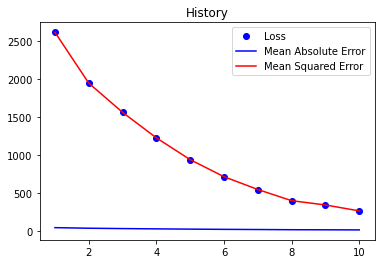

In [27]:
loss = history.history["loss"]
mae = history.history["mean_absolute_error"]
mse = history.history["mean_squared_error"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Loss')
plt.plot(epochs, mae, 'b', label='Mean Absolute Error')
plt.plot(epochs, mse, 'r', label='Mean Squared Error')
plt.title('History')
plt.legend()
plt.show()


In [28]:
img_ids = os.listdir(os.path.join(config.IMAGES_BASE_DIR, "test"))[:config.BATCH_SIZE]

In [29]:
imgs = []
for id in img_ids:
    imgs.append(util.imread_from_id(id))

In [30]:
resized = []
for img in imgs:
    resized.append(cv2.resize(img, config.INPUT_DIMS[:2]))

In [31]:
resized_tensor = np.array(resized)

In [32]:
y_pred = model.predict(resized_tensor)

1/1 [==============================] - 0s 196ms/step


In [50]:
y_pred[0] / 3

array([791.434  , 751.626  , 732.35114, 767.6446 , 763.6858 , 765.8963 ,
       790.6531 , 702.7197 , 737.4632 , 760.15106, 744.9367 , 768.02924,
       748.11127, 775.86523, 757.9641 , 744.4775 , 750.9909 , 725.66797,
       773.4665 , 754.52344, 766.4304 , 769.5222 , 710.007  , 759.7602 ,
       749.8354 , 765.18646, 711.7639 , 729.14496, 752.66626, 743.7061 ,
       765.9321 , 737.2749 , 764.6511 , 748.09814], dtype=float32)

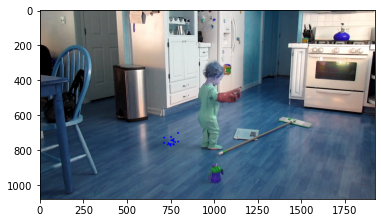

In [52]:
plt.imshow(util.draw_keypoints(imgs[0], y_pred[0] / 3, 5))

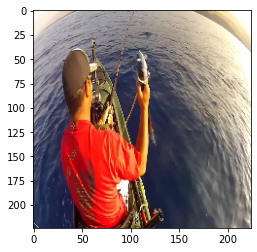

In [35]:
plt.imshow(util.to_rgb(resized[8]))